In [1]:
from __future__ import print_function
import PIL
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import text
from IPython.display import display, Math, Latex, Markdown
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
from tqdm.notebook import tqdm
import random

from scipy import stats, interpolate
from astropy.visualization import hist

from sklearn.neighbors import KernelDensity

# Markov Chain: sunny or cloudy?

Markov chains are sequences of random variables where a parameter depends only on the preceding one:

$$ p(\theta_{i+1}|\theta_i,\theta_{i-1},...) = p(\theta_{i+1}|\theta_i) $$

And so, if I am an astromer seeking for clear nights I know that:

$$\begin{cases}
\text{p(clear tomorrow | cloudy today)} = 0.5 \\
\text{p(cloudy tomorrow | cloudy today)} = 0.5 \\
\text{p(cloudy tomorrow | clear today)} = 0.1 \\
\text{p(clear tomorrow | clear today)} = 0.9 \\
\end{cases}$$

And in the end, for enough days, I should get that $ \longrightarrow $

$$ \text{p(clear)} = 0.83$$
$$\text{p(cloudy)} = 0.17$$

To build the Markov chain I have to iterate N times this procedure:

1) choose if starting day is cloudy or clear (this won't affect the result) $\rightarrow$ draw 1 random sample $x_1$ from a uniform distribution between [0,1] and
    - if $x_1$ < 0.5 $\rightarrow$ Sunny day
    - if $x_1$ > 0.5 $\rightarrow$ Cloudy day
    
2) now perform the second choice and draw 1 random sample $x_2$ from a uniform distribution between [0,1], but this time

    - if day$_0$ = cloudy $\longrightarrow$ day$_1$ = sunny if the $x_2 < p(s|c) = 0.5$ 
    - if day$_0$ = sunny $\longrightarrow$ day$_1$ = sunny if the $x_2 < p(s|s) = 0.9$
    
3) Iterate the process by extracting N $x_i$ and deciding if it's going to be clear or cloudy based on 

$$ x_i < \text{p(s|s or c)} \longrightarrow sunny $$
    
In the end I have a trace plot (remember to "_**burn it down**_"), I can show the distribution of the integral and compute its median and $\sigma_G$:

In [2]:
#declare probabilities: sunny 1 or cloudy 0
sunny_if_cloudy = 0.5
cloudy_if_cloudy = 0.5
cloudy_if_sunny = 0.1
sunny_if_sunny = 0.9 

#number of days
N = 10000

In [3]:
weather = []

prob = random.uniform(0, 1)
prob
if prob < 0.5: 
    weather.append(1)
    display(Latex(r'Starting day is sunny'),Math(r'\rightarrow'))

else : 
    weather.append(0)
    display(Latex(r'Starting day is cloudy'),Math(r'\rightarrow'))

i = 0
while i < N:
    if weather[i] == 1 :
        #print("today is sunny")
        prob_sunny = random.uniform(0, 1)
        if prob_sunny <= sunny_if_sunny: 
            weather.append(1)
            #print("also tomorrow will be sunny\n")
        else:
            weather.append(0)
            #print("tomorrow will be cloudy\n")
    if weather[i] == 0 :
        #print("today is cloudy")
        prob_sunny = random.uniform(0, 1)
        if prob_sunny <= sunny_if_cloudy:
            weather.append(1)
            #print("yey tomorrow will be sunny\n")
        else: 
            weather.append(0)
            #print("no tomorrow will be cloudy\n")
    i = i+1
#print(weather)
p_sunny = np.sum(weather)/len(weather)
print("prob of sunny days is: ", p_sunny, "\nprob of cloudy days is: ", 1-p_sunny)

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

prob of sunny days is:  0.8341165883411659 
prob of cloudy days is:  0.16588341165883413


In [4]:
print("Out of ", N, " days, the total probability of having sunny days is:", round(p_sunny*100), "%",
"\nWhereas the probability of cloudy days is:", round((1-p_sunny)*100), "%")

Out of  10000  days, the total probability of having sunny days is: 83 % 
Whereas the probability of cloudy days is: 17 %


In [5]:
days = np.arange(0, N)
y = []
for i in range(1,N+1):
    y.append(np.sum(weather[:i])/len(weather[:i]))
#y

In [6]:
burn = 2300

median_sunny = np.median(y)
sigmaG_sunny = astroMLstats.sigmaG(y)
print(np.mean(y), np.mean(y[burn:]),np.median(y), np.median(y[burn:]))
print(astroMLstats.sigmaG(y))#, astroMLstats.sigmaG(y[burn:]))

0.8366860577305307 0.8355488773286531 0.8353425872414716 0.8348343262130471
0.00531315770697952


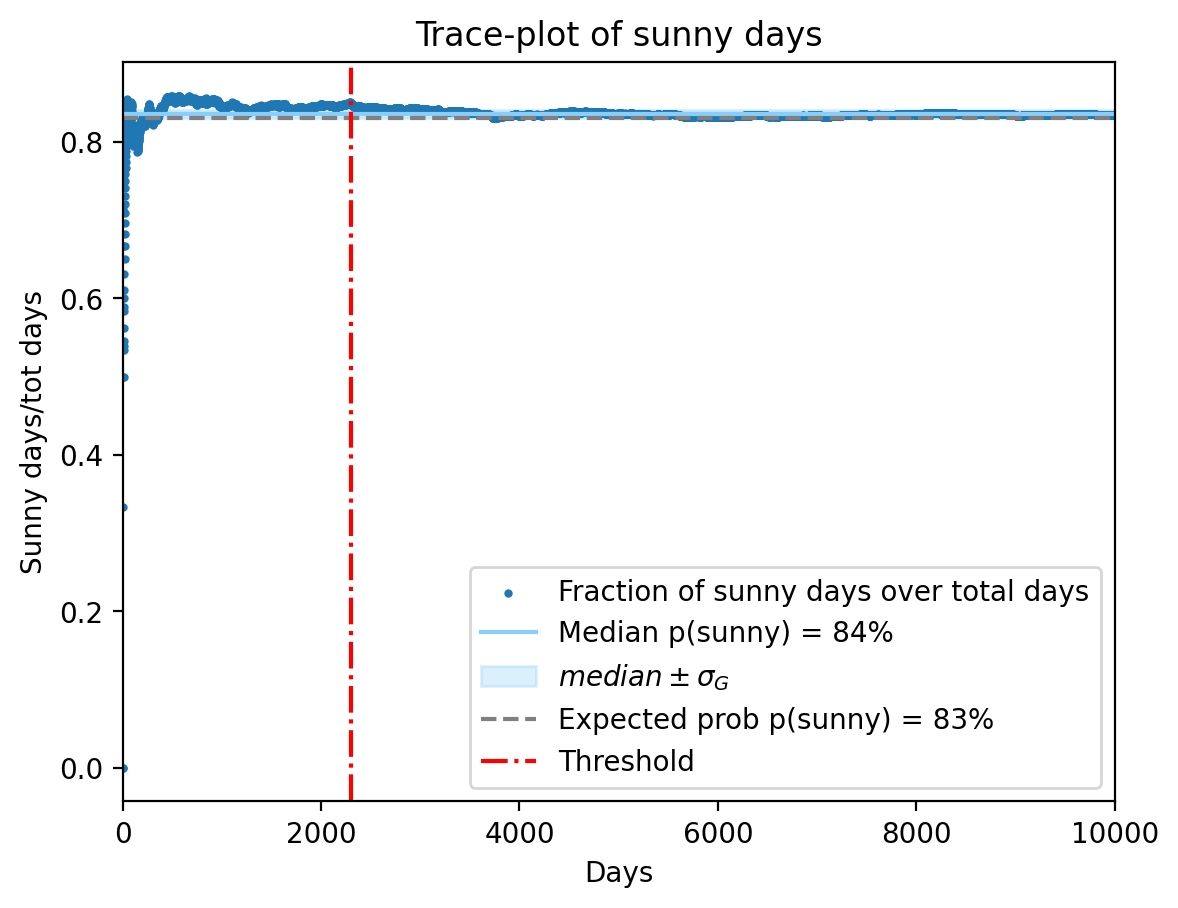

In [7]:
y1 = median_sunny - sigmaG_sunny
y2 = median_sunny + sigmaG_sunny

plt.scatter(days, y, s=4, label="Fraction of sunny days over total days")
plt.axhline(y=median_sunny, color='lightskyblue', linestyle='solid',
            label='Median p(sunny) = 'f'{round(median_sunny*100)}''%')
plt.fill_between(days, y1, y2, color='lightskyblue', label='$median \pm \sigma_G$', alpha=0.3, zorder=0)
plt.axhline(y=0.83, color='gray', linestyle='dashed', label='Expected prob p(sunny) = 83% ')
plt.axvline(x=burn, color='r', linestyle='dashdot', label='Threshold')
plt.xlabel("Days")
plt.ylabel("Sunny days/tot days")
plt.title("Trace-plot of sunny days")
plt.xlim(0,len(days))
#plt.ylim(0,1)
plt.legend()
plt.show()

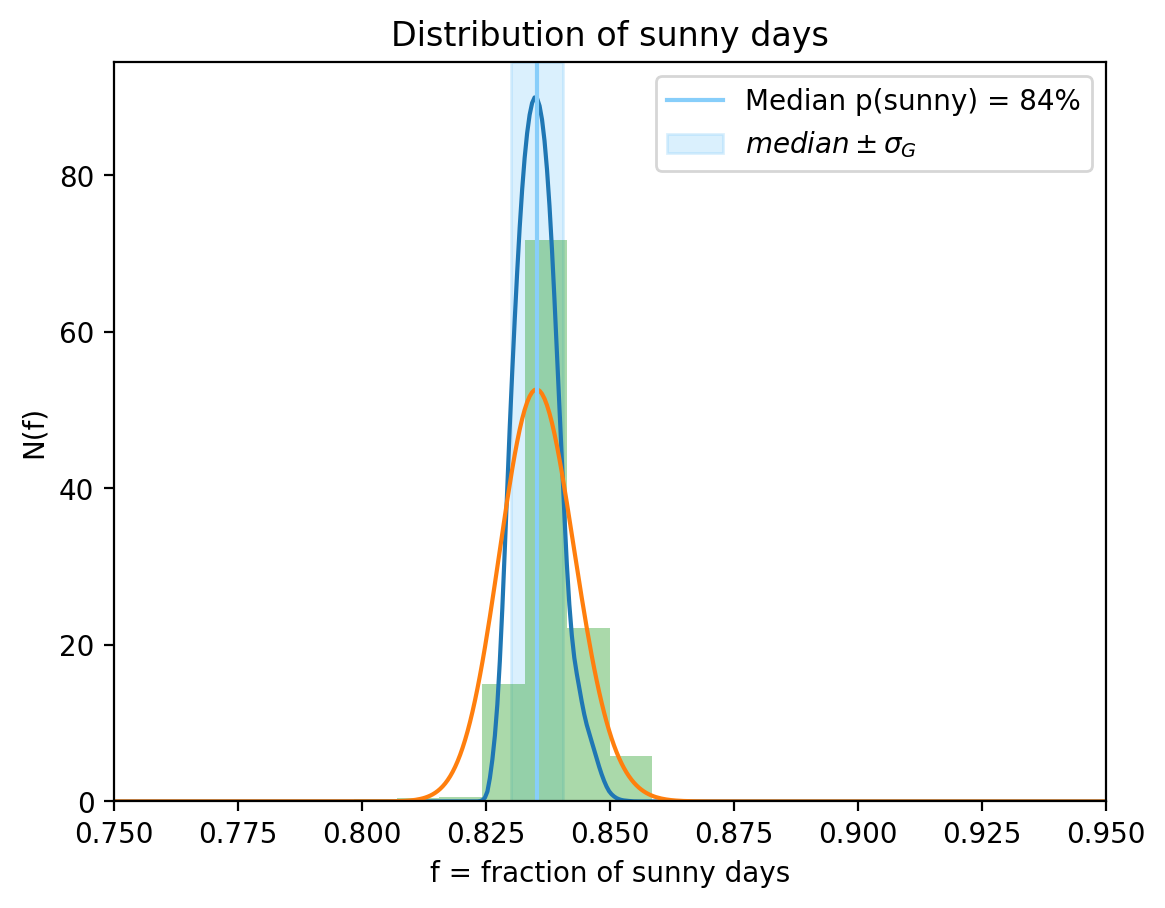

In [8]:
xgrid = np.linspace(0.5,1.,1000)  # Use this instead of 'x' for plotting

def kde_sklearn(data, bandwidth = 1.0, kernel="gaussian"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

PDFepa = kde_sklearn(np.array(y[burn:]),bandwidth=0.007,kernel="epanechnikov") 
PDFgaus = kde_sklearn(np.array(y[burn:]),bandwidth=0.007,kernel="gaussian")

x1 = median_sunny - sigmaG_sunny
x2 = median_sunny + sigmaG_sunny

plt.plot(xgrid,PDFepa)
plt.plot(xgrid,PDFgaus)
plt.hist(y, 100, density=True, histtype='stepfilled', alpha=0.4)
plt.axvline(x=median_sunny, color='lightskyblue', linestyle='solid',
            label='Median p(sunny) = 'f'{round(median_sunny*100)}''%')
plt.axvspan(x1, x2, alpha=0.3, color='lightskyblue', label='$median \pm \sigma_G$',zorder=0)
plt.xlabel("f = fraction of sunny days")
plt.ylabel("N(f)")
plt.title("Distribution of sunny days")
plt.xlim(0.75,0.95)
plt.legend()
plt.show()

## Burn in

Study with different burn-in values

In [9]:
burn1 = [1000,2300,3000,5000]

print([np.mean(y[burn1[i]:]) for i in range(len(burn1))], [np.median(y[burn1[i]:]) for i in range(len(burn1))])


[0.8368686773536274, 0.8355488773286531, 0.834823414801029, 0.8341681323175859] [0.8351905787305538, 0.8348343262130471, 0.8346321668716217, 0.8343206244222341]


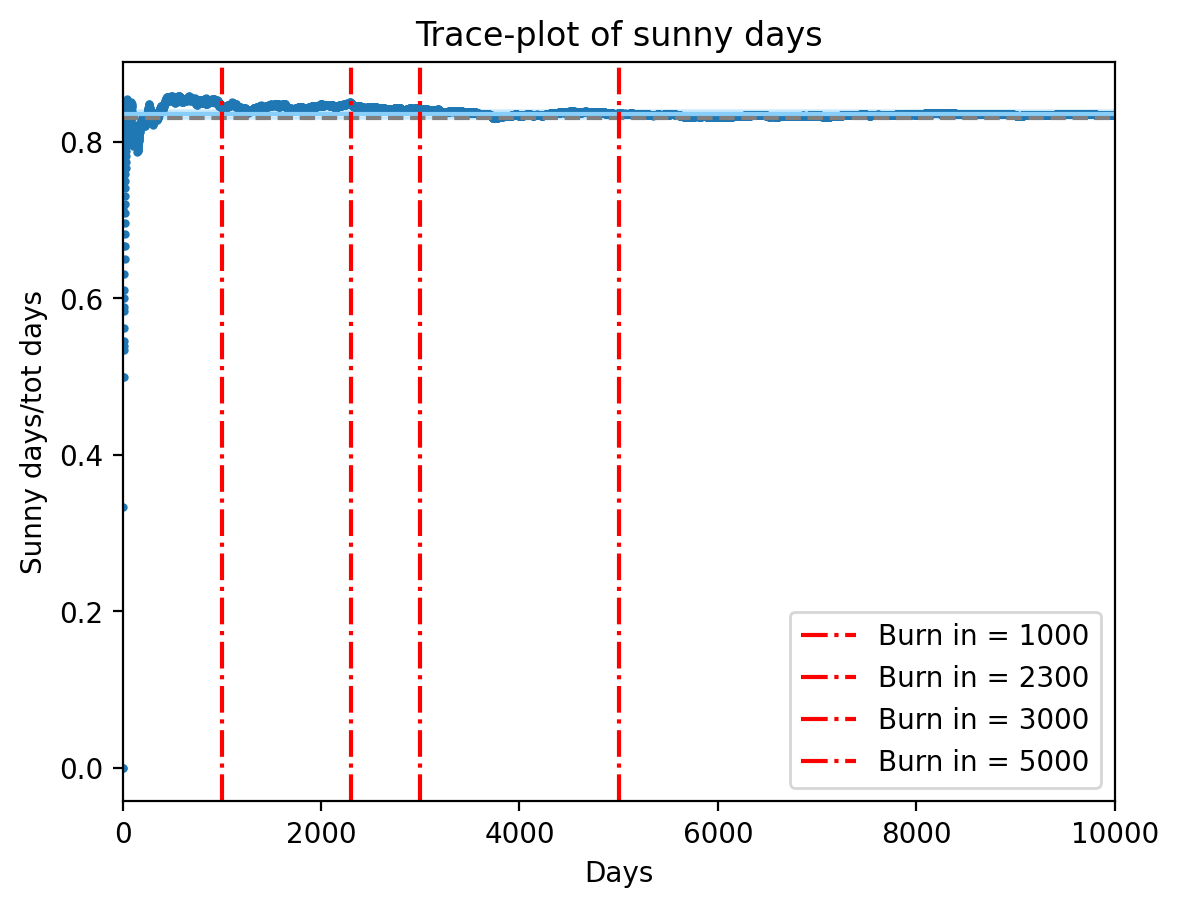

In [10]:
plt.scatter(days, y, s=4)
plt.axhline(y=median_sunny, color='lightskyblue', linestyle='solid',)
plt.fill_between(days, y1, y2, color='lightskyblue', alpha=0.3, zorder=0)
plt.axhline(y=0.83, color='gray', linestyle='dashed')

for b in burn1:
    plt.axvline(x=b, color='r', linestyle='dashdot', label='Burn in = 'f'{b}')
    
plt.xlabel("Days")
plt.ylabel("Sunny days/tot days")
plt.title("Trace-plot of sunny days")
plt.xlim(0,len(days))
#plt.ylim(0,1)
plt.legend()
plt.show()

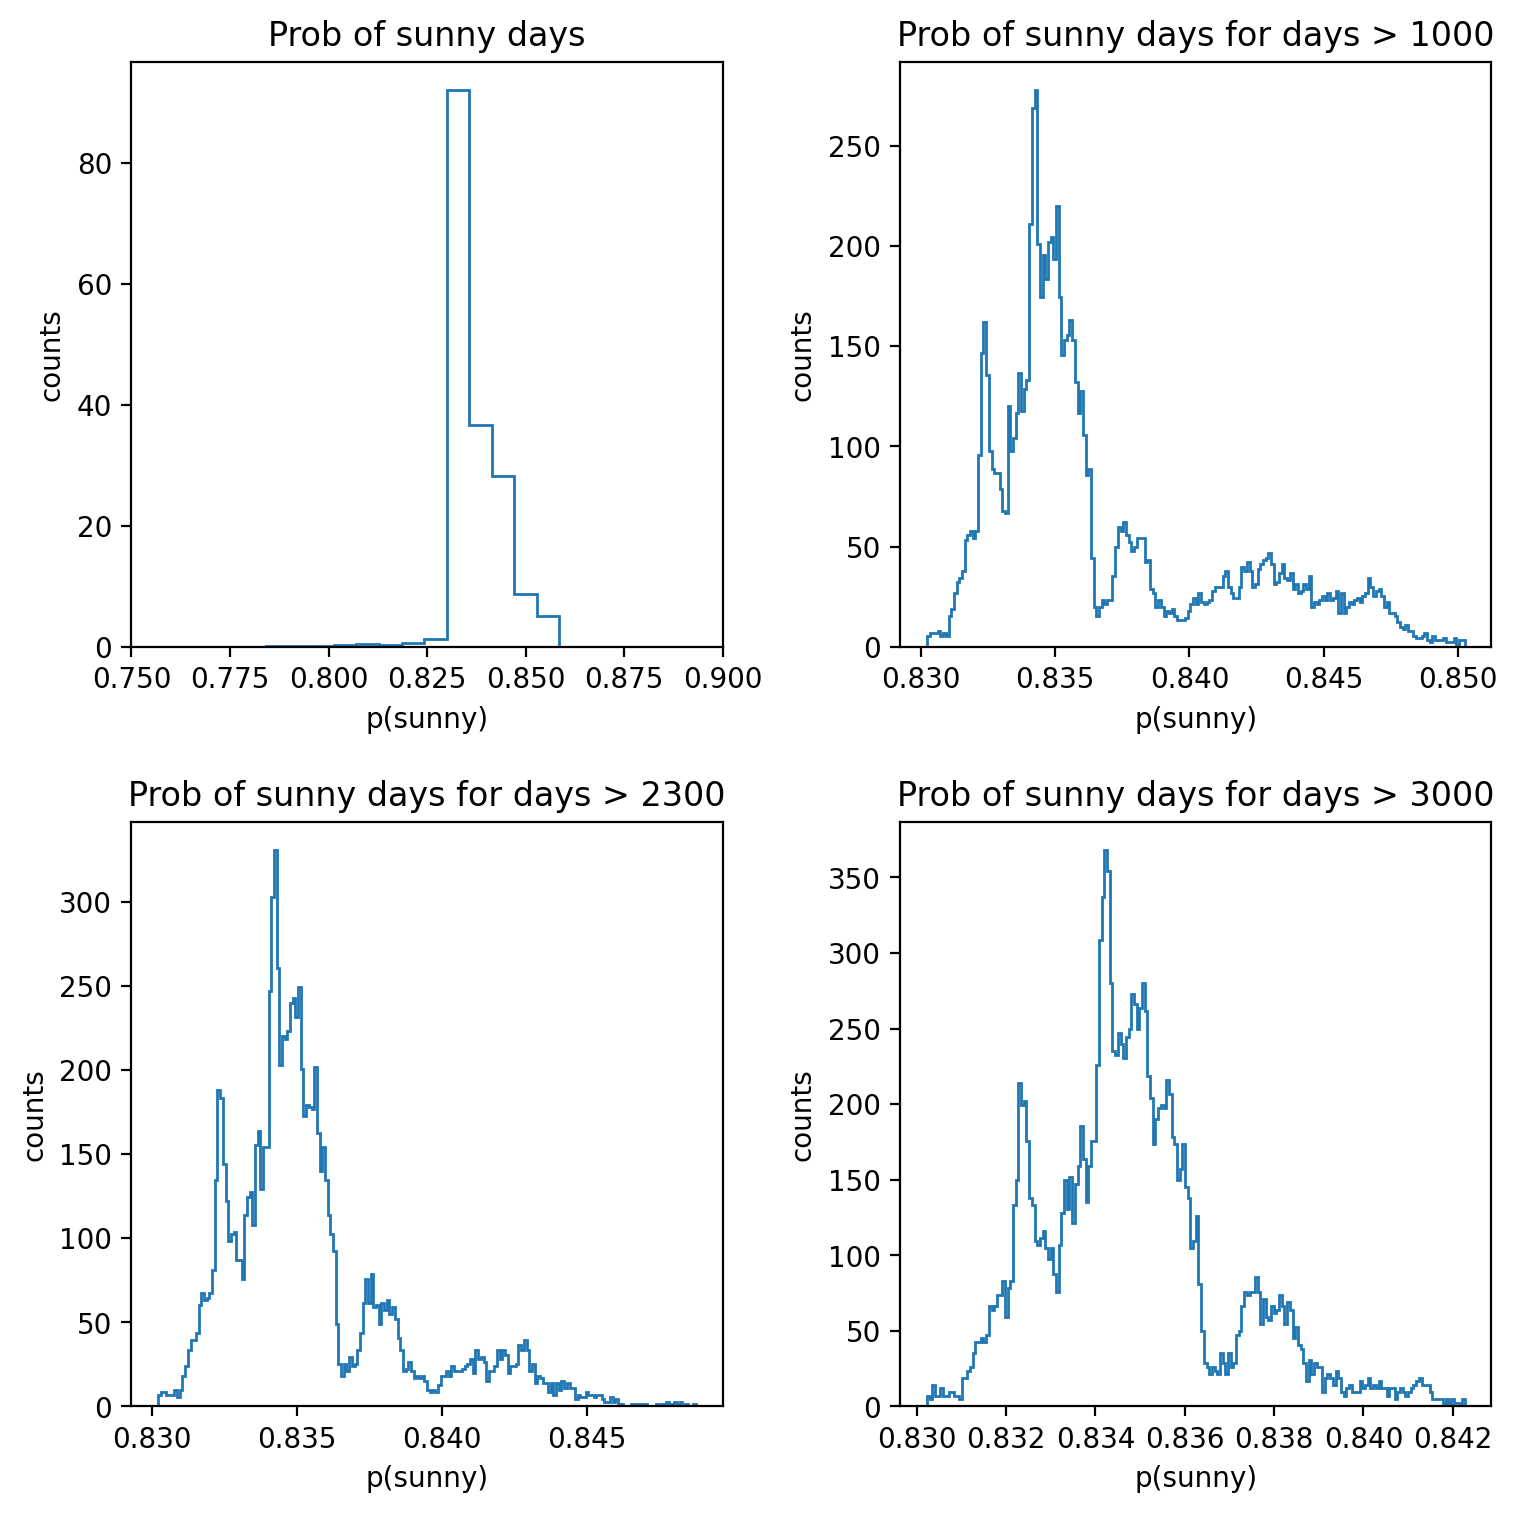

In [11]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92, wspace=0.3)

# plot a histogram of the input
ax = fig.add_subplot(221)
hist(y, bins=150, histtype='step', density=True, label='Sunny days fraction')
#ax.set_ylim(0, 350)
ax.set_title('Prob of sunny days')
ax.set_xlabel('p(sunny)')
ax.set_ylabel('counts')
plt.xlim(0.75,0.9)

ax = fig.add_subplot(222)
hist(y[burn1[0]:], bins=200, histtype='step', density=True, label='Sunny days fraction')
ax.set_title('Prob of sunny days for days > 'f'{burn1[0]}')
ax.set_xlabel('p(sunny)')
ax.set_ylabel('counts')

ax = fig.add_subplot(223)
hist(y[burn1[1]:], bins=200, histtype='step', density=True, label='Sunny days fraction')
ax.set_title('Prob of sunny days for days > 'f'{burn1[1]}')
ax.set_xlabel('p(sunny)')
ax.set_ylabel('counts')

ax = fig.add_subplot(224)
hist(y[burn1[2]:], bins=200, histtype='step', density=True, label='Sunny days fraction')
ax.set_title('Prob of sunny days for days > 'f'{burn1[2]}')
ax.set_xlabel('p(sunny)')
ax.set_ylabel('counts')

plt.show()